In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
import matplotlib.pyplot as plt

In [5]:
# defining the network
class Net(nn.Module):
  def __init__(self, n):
    super().__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(n, n, bias=False)
    self.fc1.weight.data.normal_(0, 1/np.sqrt(n))
    self.fc2 = nn.Linear(n, 1, bias=False)
    self.fc2.weight.data.normal_(0, 1/np.sqrt(n))

  def forward(self, x):
    x = self.fc1(x)
    z_hat = self.fc2(x)
    return z_hat

In [28]:
#17m
def SGDvsADAM_loss(n):
  z_target = torch.tensor([1.])
  x_input = torch.randn(n)
  
  net = Net(n)
  w1_init = net.fc1.weight.clone()
  w2_init = net.fc2.weight.clone()
  
  loss_f = nn.MSELoss()
  
  steps = 200
  alpha = 1/(2*steps)
  k = 1
  l_r = alpha*(float(n)**(-k))
  optimizer_SGD = optim.SGD(net.parameters(), lr = l_r) 
  optimizer_ADAM = optim.Adam(net.parameters(), lr = l_r)
  
  # ~~~~~SGD~~~~~
  # training with SGD
  for i in range(steps):
    optimizer_SGD.zero_grad()
    z_hat = net.forward(x_input)
    loss = loss_f(z_hat, z_target)
    loss.backward()
    optimizer_SGD.step()

  w1_final_SGD = net.fc1.weight.clone()
  #w2_final_SGD = net.fc2.weight.clone()

  
  # w1-init, w2-final
  with torch.no_grad():
    net.fc1.weight[:] = w1_init
    #second layer is already w2_final
    z_hat = net.forward(x_input)
    loss_w1_SGD = loss_f(z_hat, z_target)
                
  # w1-final, w2-init
  with torch.no_grad():
    net.fc1.weight[:] = w1_final_SGD
    net.fc2.weight[:] = w2_init
    z_hat = net.forward(x_input)
    loss_w2_SGD = loss_f(z_hat, z_target)


  #initializing nn for Adam
  with torch.no_grad():
    net.fc1.weight[:] = w1_init
    net.fc2.weight[:] = w2_init

  
  # ~~~~~Adam~~~~~
  # training with Adam
  for i in range(steps):
    optimizer_ADAM.zero_grad()
    z_hat = net.forward(x_input)
    loss = loss_f(z_hat, z_target)
    loss.backward()
    optimizer_ADAM.step()

  w1_final_Adam = net.fc1.weight.clone()
  #w2_final_Adam = net.fc2.weight.clone()
  
  # w1-init, w2-final
  with torch.no_grad():
    net.fc1.weight[:] = w1_init
    #second layer is already w2_final
    z_hat = net.forward(x_input)
    loss_w1_Adam = loss_f(z_hat, z_target)
                
  # w1-final, w2-init
  with torch.no_grad():
    net.fc1.weight[:] = w1_final_Adam
    net.fc2.weight[:] = w2_init
    z_hat = net.forward(x_input)
    loss_w2_Adam = loss_f(z_hat, z_target)
  
  return loss_w1_SGD, loss_w2_SGD, loss_w1_Adam, loss_w2_Adam

In [29]:
l1_loss_SGD=[]
l2_loss_SGD=[]
l1_loss_ADAM=[]
l2_loss_ADAM=[]

for n in range(1, 5000, 100):

  loss_SGD_L1, loss_SGD_L2, loss_ADAM_L1, loss_ADAM_L2 = SGDvsADAM_loss(n)
  l1_loss_SGD.append(loss_SGD_L1)
  l2_loss_SGD.append(loss_SGD_L2)
  l1_loss_ADAM.append(loss_ADAM_L1)
  l2_loss_ADAM.append(loss_ADAM_L2)

Text(0.5, 0.98, 'Losses vs n')

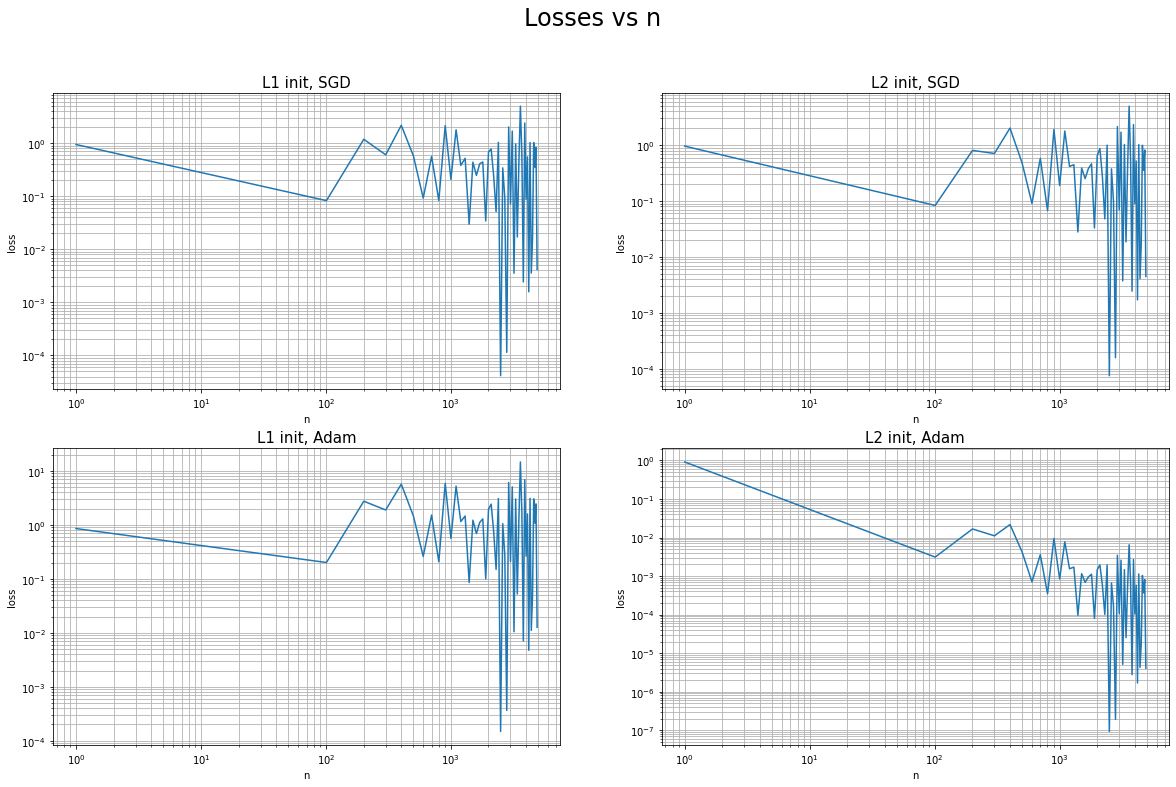

In [40]:
# plotting results

x=np.arange(1, 5000, 100)

fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(221)
ax1.loglog(x, l1_loss_SGD)
plt.ylabel('loss')
plt.xlabel('n')
ax1.set_title("L1 init, SGD", fontsize=15)
ax1.grid(True, which="both")

ax2 = fig.add_subplot(222)
ax2.loglog(x, l2_loss_SGD)
plt.ylabel('loss')
plt.xlabel('n')
ax2.set_title("L2 init, SGD", fontsize=15)
ax2.grid(True, which="both")

ax3 = fig.add_subplot(223)
ax3.loglog(x, l1_loss_ADAM)
plt.ylabel('loss')
plt.xlabel('n')
ax3.set_title("L1 init, Adam", fontsize=15)
ax3.grid(True, which="both")

ax4 = fig.add_subplot(224)
ax4.loglog(x, l2_loss_ADAM)
plt.ylabel('loss')
plt.xlabel('n')
ax4.set_title("L2 init, Adam", fontsize=15)
ax4.grid(True, which="both")

fig.suptitle("Losses vs n", fontsize=24)



Text(0.5, 0.98, 'Losses vs n')

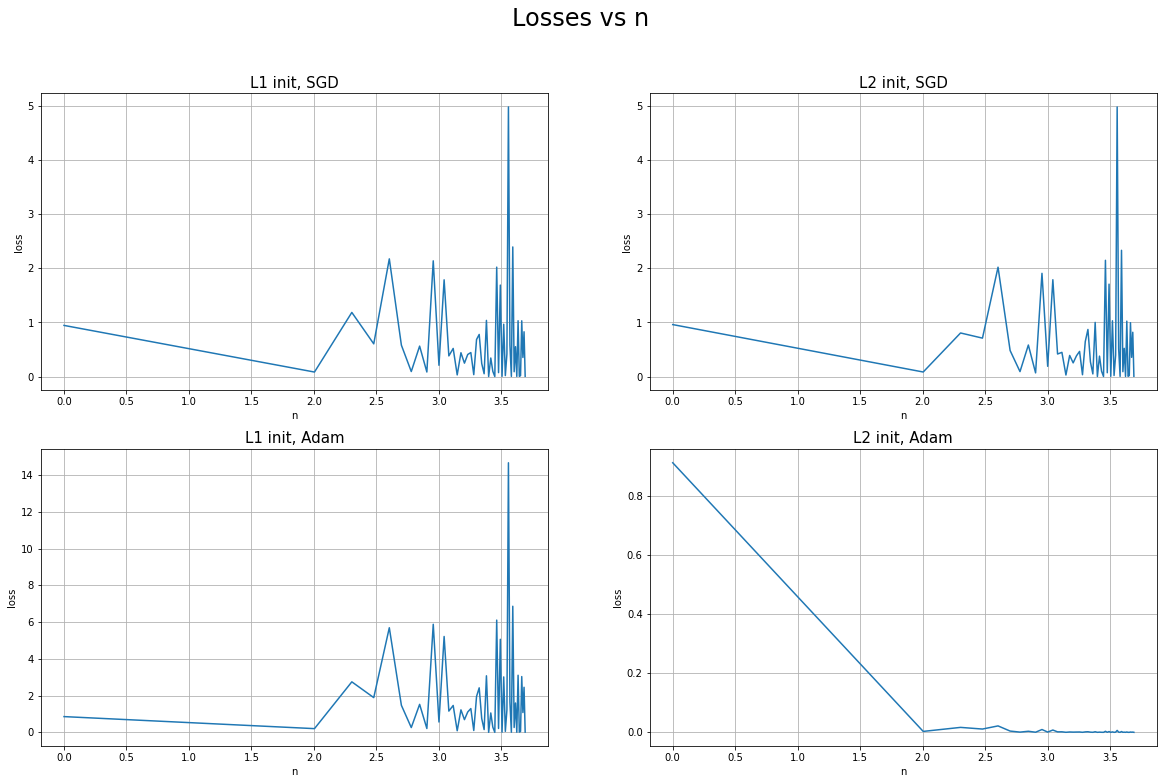

In [37]:
# plotting results

x=np.arange(1, 5000, 100)

fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(221)
ax1.plot(np.log10(x), l1_loss_SGD)
plt.ylabel('loss')
plt.xlabel('n')
ax1.set_title("L1 init, SGD", fontsize=15)
ax1.grid()

ax2 = fig.add_subplot(222)
ax2.plot(np.log10(x), l2_loss_SGD)
plt.ylabel('loss')
plt.xlabel('n')
ax2.set_title("L2 init, SGD", fontsize=15)
ax2.grid()

ax3 = fig.add_subplot(223)
ax3.plot(np.log10(x), l1_loss_ADAM)
plt.ylabel('loss')
plt.xlabel('n')
ax3.set_title("L1 init, Adam", fontsize=15)
ax3.grid()

ax4 = fig.add_subplot(224)
ax4.plot(np.log10(x), l2_loss_ADAM)
plt.ylabel('loss')
plt.xlabel('n')
ax4.set_title("L2 init, Adam", fontsize=15)
ax4.grid()

fig.suptitle("Losses vs n", fontsize=24)
